# Setup

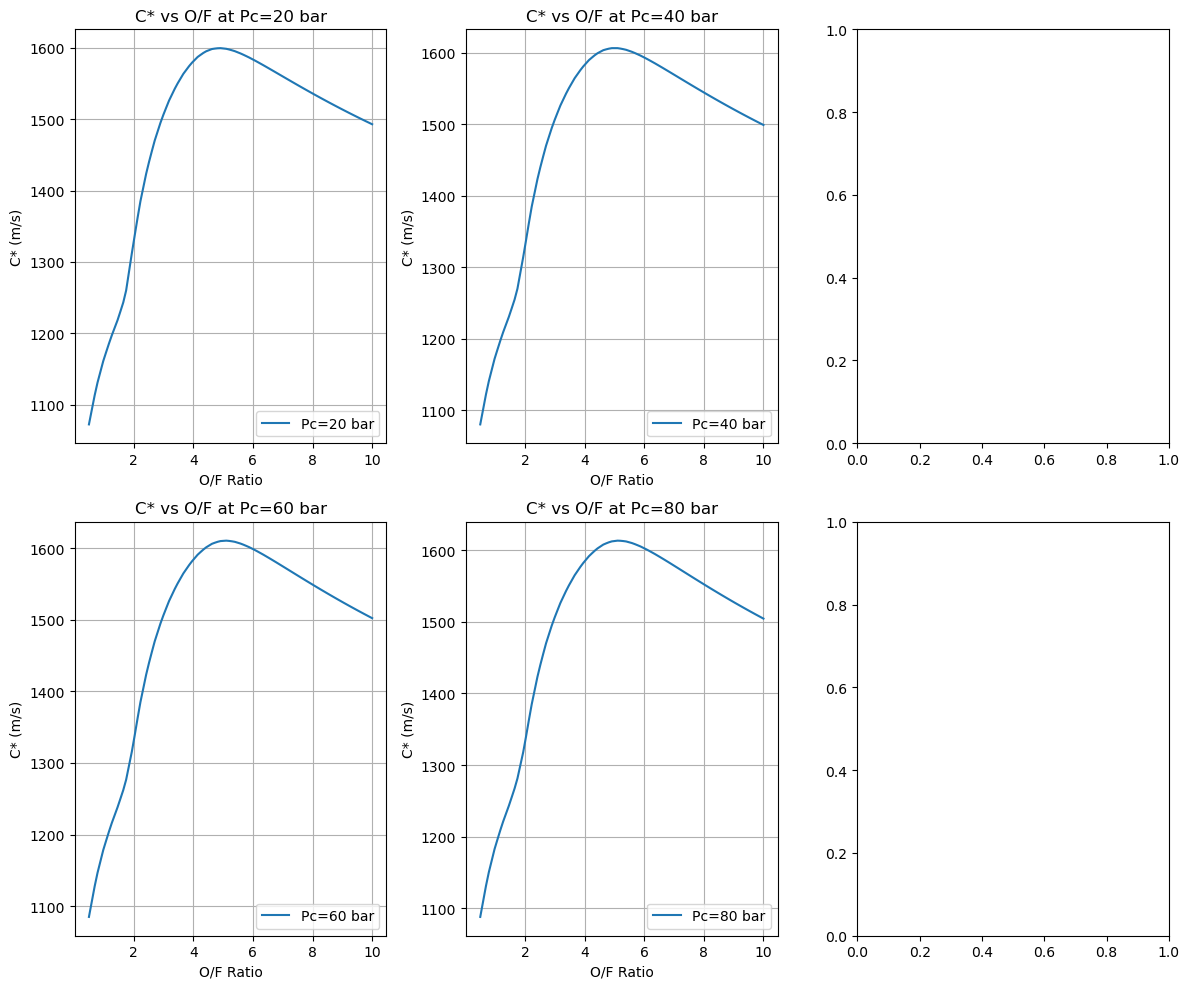

In [32]:
from rocketcea.cea_obj_w_units import CEA_Obj

cea = CEA_Obj(
    oxName = "N2O",
    fuelName = "Isopropanol",
    isp_units='sec',
    cstar_units = 'm/s',
    pressure_units='Bar',
    temperature_units='K',
    sonic_velocity_units='m/s',
    enthalpy_units='J/kg',
    density_units='kg/m^3',
    specific_heat_units='J/kg-K',
    viscosity_units='centipoise', # stored value in pa-s
    thermal_cond_units='W/cm-degC', # stored value in W/m-K
    # fac_CR=self.cr,
    make_debug_prints=False)

chamber_pressures = np.linspace(10, 100, 10)  # in bar
of_ratios = np.linspace(0.5, 10, 40)

# Run two loops to generate data then store in a 2D array

cstar_data = np.zeros((len(chamber_pressures), len(of_ratios)))

for i, pc in enumerate(chamber_pressures):
    for j, of in enumerate(of_ratios):
        cstar = cea.get_Cstar(pc, of)
        cstar_data[i, j] = cstar

# function to get cstar given pc and of by interpolating and extrapolating the data
from scipy.interpolate import RegularGridInterpolator
interpolator = RegularGridInterpolator(
    (chamber_pressures, of_ratios),
    cstar_data,
    bounds_error=False,
    fill_value=None
)
def get_cstar(pc, of):
    return interpolator((pc, of))

# plot 2x2 grid of cstar vs of for different chamber pressures
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 3, figsize=(12, 10))
chamber_pressures_to_plot = [20, 40, 60, 80]  # in bar

for i, pc in enumerate(chamber_pressures_to_plot):
    row = i // 2
    col = i % 2
    of_ratios_fine = np.linspace(0.5, 10, 100)
    cstar_values = get_cstar(pc, of_ratios_fine)

    ax[row, col].plot(of_ratios_fine, cstar_values, label=f'Pc={pc} bar')
    ax[row, col].set_title(f'C* vs O/F at Pc={pc} bar')
    ax[row, col].set_xlabel('O/F Ratio')
    ax[row, col].set_ylabel('C* (m/s)')
    ax[row, col].grid(True)
    ax[row, col].legend()

plt.tight_layout()
plt.show()

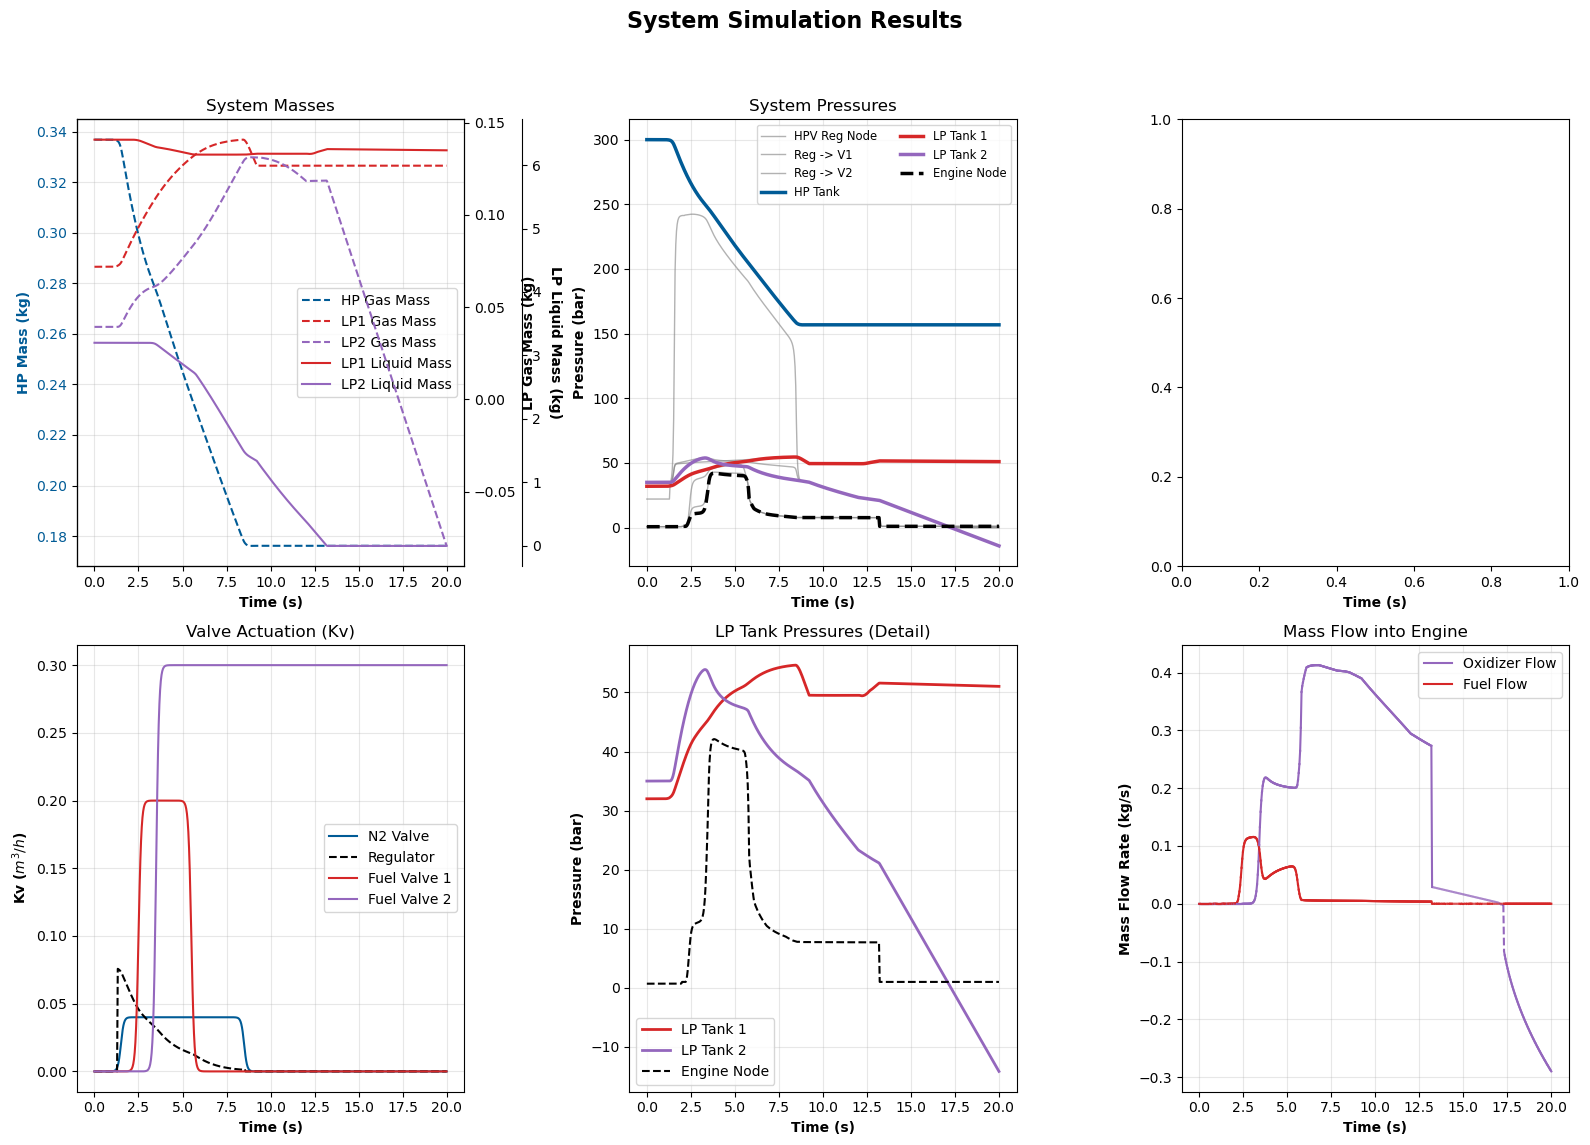

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root
import matplotlib.pyplot as plt
from dataclasses import dataclass
import cProfile
import math

@dataclass
class Gas:
    R: float # J/(kg·K)
    gamma: float

    
@dataclass
class Liquid:
    density: float
    

import numpy as np

def gasFlowrate(Kv, P_1, P_2, T_1, gas, assumeChoked=False):
    """
    Calculates gas mass flow rate using the Simplified Kv Model (Tameson).
    Includes broadcasting to handle mix of scalar and array inputs.
    """
    
    if np.isscalar(P_1) and np.isscalar(P_2) and np.isscalar(Kv) and np.isscalar(T_1):
            P_1 = float(P_1)
            P_2 = float(P_2)
            Kv = float(Kv)
            T_1 = float(T_1)
            
            # Constants for Standard Conditions (NTP: 0°C, 1 atm)
            P_N_Pa = 101325.0       # Pa
            T_N_K  = 273.15         # K
            rho_n  = P_N_Pa / (gas.R * T_N_K) # Normal Density (kg/m^3)

            # Convert Pressures to BAR for the Kv formula
            p1_bar = P_1 / 1e5
            p2_bar = P_2 / 1e5

            if p2_bar > p1_bar:
                pu = p2_bar
                pd = p1_bar
                sign = -1.0
            else:
                pu = p1_bar
                pd = p2_bar
                sign = 1.0

            # Simplified Model assumes choking at P_down < P_up / 2
            critical_ratio = 0.5
            
            # Determine if flow is choked
            is_choked = (pd < (pu * critical_ratio)) or (assumeChoked == True) or (assumeChoked == 1)

            if not is_choked:
                dp_sub = pu - pd
                # Protect against negative sqrt near zero
                term = max(dp_sub * pd, 0.0)
                q_n = 514.0 * Kv * math.sqrt(term / (rho_n * T_1))
            else:
                q_n = 257.0 * Kv * pu * math.sqrt(1.0 / (rho_n * T_1))

            # Final Conversion to Mass Flow (kg/s)
            m_dot = q_n * rho_n / 3600.0
            return m_dot * sign
    
    # --- BROADCASTING FIX ---
    # This ensures that if Kv is [1] and P_1 is length 5, Kv becomes length 5
    try:
        P_1, P_2, T_1, Kv = np.broadcast_arrays(P_1, P_2, T_1, Kv)
    except ValueError:
        raise ValueError("Input shapes (P, T, Kv) are incompatible and cannot be broadcast together.")

    # Constants for Standard Conditions (NTP: 0°C, 1 atm)
    P_N_Pa = 101325.0       # Pa
    T_N_K  = 273.15         # K
    rho_n  = P_N_Pa / (gas.R * T_N_K) # Normal Density (kg/m^3)

    # Convert Pressures to BAR for the Kv formula
    p1_bar = P_1 / 1e5
    p2_bar = P_2 / 1e5

    # --- 2. Flow Direction Logic ---
    # Identify reverse flow (P2 > P1) and swap variables for calculation
    reverse_mask = p2_bar > p1_bar
    
    pu = np.where(reverse_mask, p2_bar, p1_bar) # Upstream Pressure (bar)
    pd = np.where(reverse_mask, p1_bar, p2_bar) # Downstream Pressure (bar)

    # --- 3. Choked Flow Determination ---
    # Simplified Model assumes choking at P_down < P_up / 2
    critical_ratio = 0.5
    
    # Handle assumeChoked (scalar or array)
    assumeChoked = np.atleast_1d(assumeChoked)
    # Broadcast assumeChoked to shape of P_1 if necessary, or let numpy broadcasting handle the 'or' logic
    
    # Determine if flow is choked (physically choked OR forced by user)
    # Note: We use bitwise OR (|) for boolean arrays
    is_choked = (pd < (pu * critical_ratio)) | ((assumeChoked == True) | (assumeChoked == 1))

    # --- 4. Flow Rate Calculation (Q_n in Nm^3/h) ---
    q_n = np.zeros_like(pu)

    # A. Subcritical Flow (P_down > P_up / 2)
    sub_idx = ~is_choked
    if np.any(sub_idx):
        dp_sub = pu[sub_idx] - pd[sub_idx]
        # Protect against negative sqrt near zero
        term = np.maximum(dp_sub * pd[sub_idx], 0) 
        
        q_n[sub_idx] = 514 * Kv[sub_idx] * np.sqrt(
            term / (rho_n * T_1[sub_idx])
        )

    # B. Supercritical / Choked Flow (P_down < P_up / 2)
    choked_idx = is_choked
    if np.any(choked_idx):
        q_n[choked_idx] = 257 * Kv[choked_idx] * pu[choked_idx] * np.sqrt(
            1.0 / (rho_n * T_1[choked_idx])
        )

    # --- 5. Final Conversion to Mass Flow (kg/s) ---
    m_dot = q_n * rho_n / 3600.0

    # Apply sign for reverse flow
    m_dot = np.where(reverse_mask, -m_dot, m_dot)

    return m_dot

import numpy as np

def liquidFlowrate(Kv, P_1, P_2, liquid):
    """
    Calculates liquid mass flow rate (kg/s) using Kv.
    
    Parameters:
        Kv  : Flow coefficient (m^3/h water @ 1 bar dP)
        P_1 : Upstream pressure (Pa)
        P_2 : Downstream pressure (Pa)
        liquid : Object with .density attribute (kg/m^3)
        
    Returns:
        m_dot : Mass flow rate (kg/s). Negative value indicates reverse flow.
    """
    # --- 1. Broadcast Inputs ---
    # Ensure inputs match shapes (handles scalar Kv with array Pressure)

        # --- OPTIMIZATION: Scalar Fast Path ---
    if np.isscalar(P_1) and np.isscalar(P_2) and np.isscalar(Kv):
        P_1 = float(P_1)
        P_2 = float(P_2)
        Kv = float(Kv)
        
        dp = P_1 - P_2
        CONST_LIQUID = 1.0 / 36000.0
        
        if dp >= 0:
            return CONST_LIQUID * Kv * math.sqrt(dp * liquid.density)
        else:
            return -CONST_LIQUID * Kv * math.sqrt(-dp * liquid.density)

    P_1 = np.atleast_1d(P_1).astype(float)
    P_2 = np.atleast_1d(P_2).astype(float)
    Kv  = np.atleast_1d(Kv).astype(float)
    
    try:
        P_1, P_2, Kv = np.broadcast_arrays(P_1, P_2, Kv)
    except ValueError:
        raise ValueError("Input shapes are incompatible.")

    # --- 2. Calculate Pressure Drop ---
    dp = P_1 - P_2
    
    # --- 3. Calculate Mass Flow ---
    # Formula: m_dot = (Kv / 36000) * sqrt(rho * abs(dp))
    # We use np.sign(dp) to handle reverse flow direction automatically
    
    # Constant derived from: 0.1 (unit conversions) / 3600 (hours to seconds)
    CONST_LIQUID = 1 / 36000.0
    
    m_dot = (np.sign(dp) * CONST_LIQUID * Kv * np.sqrt(np.abs(dp) * liquid.density))

    return m_dot

from typing import Union, Callable, Any
from numpy.typing import NDArray
from dataclasses import dataclass, field

FloatOrArray = Union[float, NDArray[np.float64]]

@dataclass
class Tank:
    name: str
    volume: float  # m^3
    pressure: float # Pa
    gas: Gas | None= None        # Gas object
    gas_temp: float | None = None       # K
    liquid: Liquid | None= None  # Liquid object
    mass_liquid: float = 0  # kg
    liquid_temp: float | None = None  # K
    mass_gas: float = field(init=False)
    def __post_init__(self):
        if self.gas is not None:
            if self.gas_temp is None:
                raise ValueError("gas_temp must be provided if gas is specified.")
            R = self.gas.R
            T = self.gas_temp
            V = self.volume
            P = self.pressure

            liquid_volume = 0.0
            if self.mass_liquid is not None and self.liquid is not None:
                liquid_volume = self.mass_liquid / self.liquid.density
            
            self.mass_gas = (P * (V - liquid_volume)) / (R * T)
        else:
            self.mass_gas = 0.0

        if self.liquid is not None:
            if self.liquid_temp and self.gas_temp is None:
                raise ValueError("liquid_temp must be provided if liquid is specified and temperature cannot be assumed from gas_temp.")
            
            if self.liquid_temp is None:
                self.liquid_temp = self.gas_temp
                
            if self.mass_liquid is None:
                raise ValueError("mass_liquid must be provided if liquid is specified.")

@dataclass
class FlowComponent:
    name: str
    # kv can be a simple float OR a function that returns a float
    # The function signature is flexible: f(t, P_up, P_down)
    kv: Union[FloatOrArray, Callable[[FloatOrArray, FloatOrArray, FloatOrArray], FloatOrArray]]

    def get_kv(self, t: FloatOrArray, P_up: FloatOrArray, P_down: FloatOrArray) -> FloatOrArray:
        """
        Returns the Kv value. 
        If inputs are arrays, returns an array. 
        If inputs are scalars, returns a float (usually).
        """
        if callable(self.kv):
            # The lambda handles the logic
            return self.kv(t, P_up, P_down)
        else:
            # If kv is a constant (e.g., a pipe), just return it.
            # Note: If you multiply this scalar return value by an array 
            # downstream (e.g. flow = kv * sqrt(dp_array)), 
            # Numpy broadcasting handles it automatically.
            return self.kv
        

def timed_valve_kv(t, maxKv, t_open, t_close, t_ramp, leak_kv=1e-6):
    """
    Single function for a full valve cycle using Smooth Sigmoids (S-Curves).
    Best for ODE solvers (scipy.solve_ivp) as it has continuous derivatives.
    
    Parameters:
        t       : Current time (scalar or array)
        maxKv   : Maximum Kv
        t_open  : Start time for OPENING
        t_close : Start time for CLOSING
        t_ramp  : Time duration for the transition (approximate)
        leak    : Minimum Kv value (to prevent solver singularities)
    """
    # 1. Standardize input
    if np.isscalar(t):
        t = float(t)
        k = 12.0 / t_ramp
        center_open = t_open + (t_ramp / 2.0)
        center_close = t_close + (t_ramp / 2.0)
        
        # Opening: standard sigmoid
        sig_open = 1.0 / (1.0 + math.exp(-k * (t - center_open)))
        
        # Closing: inverted sigmoid
        sig_close = 1.0 - (1.0 / (1.0 + math.exp(-k * (t - center_close))))
        
        Kv = maxKv * sig_open * sig_close
        return max(Kv, leak_kv)

    # 1. Standardize input
    is_scalar = np.isscalar(t) or np.ndim(t) == 0


    is_scalar = np.isscalar(t) or np.ndim(t) == 0
    t = np.atleast_1d(t).astype(float)
    
    # 2. Calculate Steepness (k)
    # A 'k' factor of 12/t_ramp ensures the curve completes ~99% of its 
    # transition within the t_ramp window.
    k = 12.0 / t_ramp
    
    # 3. Calculate Centers
    # We center the S-curve at the midpoint of the ramp
    center_open = t_open + (t_ramp / 2.0)
    center_close = t_close + (t_ramp / 2.0)
    
    # 4. Generate Curves (0.0 to 1.0)
    # Opening: standard sigmoid (low -> high)
    # Equation: 1 / (1 + e^-k(t - center))
    sig_open = 1.0 / (1.0 + np.exp(-k * (t - center_open)))
    
    # Closing: inverted sigmoid (high -> low)
    # Equation: 1 - sigmoid
    sig_close = 1.0 - (1.0 / (1.0 + np.exp(-k * (t - center_close))))
    
    # 5. Combine
    # We multiply them. If either is 0 (closed), the result is 0.
    # This naturally creates a smooth bell-shape if the valve closes 
    # before it finishes opening.
    Kv = maxKv * sig_open * sig_close
    
    # 6. Apply Leak (Clip)
    Kv = np.maximum(Kv, leak_kv)
    
    if is_scalar:
        return Kv.item()
    return Kv

def regulator_kv(P_up, P_down, set_pressure, reg_constant=300, leak_kv=1e-6):
    """Calculates the Kv of a pressure regulator based on upstream and downstream pressures.

    Parameters:
        P_up        : Upstream pressure
        P_down      : Downstream pressure
        set_pressure: Set pressure of the regulator
        reg_constant: Regulator constant (default: 300)
        leak_kv     : Minimum Kv value to prevent singularities (default: 1e-8)

    Huge assumptions are made:
        - Regulator only allows flow from high to low pressure
        - Linear relationship between pressure drop and Kv above set pressure
        - Below set pressure, only leak flow is allowed
        - No dynamic behavior (instantaneous response)
    Returns:
        reg_kv      : Calculated Kv value of the regulator
    """
    if np.isscalar(P_up) and np.isscalar(P_down):
        P_up = float(P_up)
        P_down = float(P_down)
        
        reg_dp = set_pressure - P_down
        # if reg_dp > 0 and P_up > set_pressure:
        if reg_dp > 0 and P_up > P_down:
            reg_kv = reg_dp / reg_constant / 1e5
        else:
            reg_kv = leak_kv
            
        return max(reg_kv, leak_kv)

    is_scalar = np.isscalar(P_up) or np.ndim(P_up) == 0
    P_up = np.atleast_1d(P_up).astype(float)
    P_down = np.atleast_1d(P_down).astype(float)

    reg_dp = set_pressure - P_down
    # reg_kv = np.where((reg_dp > 0) & (P_up > set_pressure), reg_dp / reg_constant / 1e5, leak_kv)
    reg_kv = np.where((reg_dp > 0) & (P_up > P_down), reg_dp / reg_constant / 1e5, leak_kv)
    reg_kv = np.maximum(reg_kv, leak_kv)
    if is_scalar:
        return reg_kv.item()
    return reg_kv


@dataclass
class FluidNode:
    name: str
    pressure: float | None = None
    temperature: float| None = None
    fluid: Gas | Liquid | None = None
    tank: Tank | None = None
    is_engine: bool = False
    constant_pressure: bool = False
    nodeComponentTuples: list[tuple["FluidNode", FlowComponent, bool]] | None = None # (Connected Node, Component, component_is_upstream)

    def connect_nodes(self, nodeComponentTuples: list[tuple["FluidNode", FlowComponent, bool]]):
        if self.nodeComponentTuples is None:
            self.nodeComponentTuples = []
        self.nodeComponentTuples.extend(nodeComponentTuples)

from scipy.optimize import least_squares    

def solve_network_pressures(all_nodes: list[FluidNode], t: float):


    sorted_nodes = sorted(all_nodes, key=lambda n: n.pressure if n.pressure is not None else -np.inf, reverse=True)

    for node in sorted_nodes:
        if node.tank or node.constant_pressure:
            continue

        best_neihbor = None
        max_p = -np.inf

        for neighbor, _, _ in node.nodeComponentTuples:
            if neighbor.pressure is not None and neighbor.pressure > max_p:
                max_p = neighbor.pressure
                best_neihbor = neighbor

        if best_neihbor and best_neihbor.fluid:
            node.fluid = best_neihbor.fluid
            if node.temperature is None:
                node.temperature = best_neihbor.temperature
            if node.pressure is None:
                node.pressure = best_neihbor.pressure / 2
                
    # if iterated == 1:
    #     for node in all_nodes:
    #         print(f"Initial pressure guess for node '{node.name}': {node.pressure}")


    variable_nodes = [node for node in all_nodes if node.tank is None and not node.constant_pressure]

    
    # print(f"Solving pressures at time {t:.2f}s for nodes {[node.name for node in variable_nodes]}")

    if not variable_nodes:
        return
    
    # Initial guess for pressures, set undefined pressures to 1 bar
    # x0 = np.array([node.pressure if node.pressure is not None and not np.isnan(node.pressure) else 1e5 for node in variable_nodes])
    x0 = np.array([node.pressure for node in variable_nodes])

    def residuals(pressures):
        
        # for node in all_nodes:
        #     print(f"Node '{node.name}': Pressure={node.pressure}, Fluid={node.fluid}")

        for i, node in enumerate(variable_nodes):
            node.pressure = pressures[i]

        net_flows = []

        for node in variable_nodes:
            net_m = 0.0
            
            if node.nodeComponentTuples is None:
                raise ValueError(f"FluidNode '{node}' has no connected components.")
            
            #------------------------------------------------------------------------------------------------
            # hardcoding engine for now 
            # ------------------------------------------------------------------------------------------------
            if node.is_engine:
                # Fuel comes from tank 2, through fuel_valve_2, but the node is test_valve_1_to_test_valve_2
                # Oxidizer comes from lp_tank through test_valve_2
                # 1. make sure both nodes are liquids

                oxidizer_node = None
                oxidizer_component = None

                fuel_node = None
                fuel_component = None

                atmosphere_node = None

                for connected_node, component, _ in node.nodeComponentTuples:
                    if connected_node.name == "LP tank 2":
                        oxidizer_node = connected_node
                        oxidizer_component = component
                    elif connected_node.name == "Between Test Valve 1 and Test Valve 2":
                        fuel_node = connected_node
                        fuel_component = component
                    elif connected_node.name == "Atmosphere":
                        atmosphere_node = connected_node

                if oxidizer_node is None or fuel_node is None or oxidizer_component is None or fuel_component is None:
                    raise ValueError(f"Engine node must be connected to both oxidizer and fuel nodes. Current connections and components. Current node: '{node.name}' connections: {[ (n.name, c.name) for n,c,_ in node.nodeComponentTuples]}")
                
                oxidizer_type = oxidizer_node.fluid
                fuel_type = fuel_node.fluid

                m_dot_oxidizer, _ = get_component_flows(t, oxidizer_node, node, oxidizer_component)
                m_dot_fuel, _ = get_component_flows(t, fuel_node, node, fuel_component)

                if not isinstance(oxidizer_type, Liquid) or not isinstance(fuel_type, Liquid):
                    # Set itself to act exactly like atmosphereic node if fluids are not liquids
                    # node.pressure = 101325.0
                    
                    # ox_mdot_to_atm, _ = get_component_flows(t, oxidizer_node, atmosphere_node, oxidizer_component)
                    # fuel_mdot_to_atm, _ = get_component_flows(t, fuel_node, atmosphere_node, fuel_component)

                    # net_m += ox_mdot_to_atm
                    # net_m += fuel_mdot_to_atm
                    # net_m -= m_dot_oxidizer
                    # net_m -= m_dot_fuel

                    # net_flows.append(net_m)

                    if node.pressure is None or np.isnan(node.pressure):
                        raise ValueError("Engine node pressure is not defined.")
                    net_flows.append((node.pressure - 101325.0) * 1e-5)

                    continue

                # Now for the fun stuff
                if node.pressure is None or np.isnan(node.pressure):
                    raise ValueError("Engine node pressure is not defined.")

                # of_ratio = m_dot_oxidizer / m_dot_fuel
                # cstar = get_cstar(node.pressure / 1e5, of_ratio)
                # A_t = 0.0001  # m^2, assume a throat area, radius = 0.018 m 
                # net_m += node.pressure * A_t / cstar
                # net_m -= m_dot_oxidizer
                # net_m -= m_dot_fuel

                # net_flows.append(net_m)

                # 1. Calculate C* and Throat Area
                of_ratio = m_dot_oxidizer / (m_dot_fuel + 1e-9) # Avoid div/0
                cstar = get_cstar(node.pressure / 1e5, of_ratio)
                A_t = 0.0001 

                # 2. DEFINE ATMOSPHERIC PRESSURE
                P_atm = 101325.0 

                # 3. FIX: CONDITION THE OUTFLOW
                # If Engine Pressure > Atmosphere, use Choked Flow equation
                # If Engine Pressure <= Atmosphere, Flow is effectively zero (or limited)
                
                # We use a "Smooth Max" or simple logic to prevent the vacuum effect.
                # This ensures the solver never drives P_engine below P_atm just to match flows.
                
                if node.pressure > P_atm:
                    # Standard Choked Flow
                    m_dot_nozzle = node.pressure * A_t / cstar
                else:
                    # Unchoked / No Flow (Engine is effectively off)
                    # We add a tiny 'leak' term just to keep the solver mathematically happy
                    # but effectively flow is zero.
                    m_dot_nozzle = (node.pressure - P_atm) * 1e-9 

                net_m += m_dot_nozzle
                net_m -= m_dot_oxidizer
                net_m -= m_dot_fuel

                # 4. BOUNDARY GUARD
                # Force a high residual penalty if the solver guesses negative pressure
                if node.pressure < 0:
                    net_flows.append(1e9)
                    continue
                net_flows.append(net_m)
                continue
                

            
            #------------------------------------------------------------------------------------------------
            # end of hardcoded engine
            # ------------------------------------------------------------------------------------------------

            for connected_node, component, component_is_upstream in node.nodeComponentTuples:
                if component_is_upstream:
                    m_dot, _ = get_component_flows(t, connected_node, node, component)
                    if np.isnan(m_dot): m_dot = 0.0
                    m_dot = float(m_dot)
                    net_m += m_dot
                else :
                    m_dot, _ = get_component_flows(t, node, connected_node, component)
                    if np.isnan(m_dot): m_dot = 0.0
                    m_dot = float(m_dot)
                    net_m -= m_dot
            net_flows.append(net_m)

            # Bring flows to 1e5 scale for numerical stability
            # net_flows = [flow * 1e5 for flow in net_flows]
            # net_flows = [flow / 1e2 for flow in net_flows]
        
        # print(f"At time {t:.2f}s, Residuals: {net_flows}")
        # if iterated == 1:
        #     for i, node in enumerate(variable_nodes):
        #         print(f"At time {t:.2f}s, Node '{node.name}': Attempted Pressure={pressures[i]}, Net Flow={net_flows[i]}")
        # print(f"Attemped pressures: {[node.pressure for node in variable_nodes]}")
        return np.array(net_flows)
    
    # sol = root(residuals, x0, method='hybr', tol=1e-8)
    bounds_limits = (np.full_like(x0, 1e3), np.full_like(x0, 1e8))  # Example bounds: 1 kPa to 100 MPa
    sol = least_squares(residuals, x0, bounds=bounds_limits, max_nfev=100)
    # if not sol.success:
    #     print(f"Warning: Pressure solver did not converge at time {t}s. Message: {sol.message}")

    for i, node in enumerate(variable_nodes):
        node.pressure = sol.x[i]

        


    

def get_component_flows(t, node_up: FluidNode, node_down: FluidNode, component: FlowComponent):

    P_up = node_up.pressure
    P_down = node_down.pressure

    if P_up is None or P_down is None:
        raise ValueError("Both upstream and downstream pressures must be defined.")

    kv = component.get_kv(t, P_up, P_down)
    fluid_higherpressure = node_up.fluid if P_up >= P_down else node_down.fluid

    # print(f"Node_up fluid: {node_up.fluid}, Node_down fluid: {node_down.fluid}, Fluid higher pressure: {fluid_higherpressure}")
    # print(f"Component '{component.name}': P_up={P_up}, P_down={P_down}, kv={kv}, fluid={fluid_higherpressure}")

    # NOTE This check fails the solver
    # if P_up < 0 or P_down < 0:
    #     raise ValueError(f"Negative pressure encountered: P_up={P_up}, P_down={P_down} on component '{component.name}'")

    try:
        if isinstance(fluid_higherpressure, Gas):
            T_higherpressure = node_up.temperature if P_up >= P_down else node_down.temperature
            m_dot = gasFlowrate(kv, P_up, P_down, T_higherpressure, fluid_higherpressure)
            if np.isnan(m_dot):
                raise ValueError(f"Calculated NaN mass flow rate for component '{component.name}' with P_up={P_up}, P_down={P_down}, T_higherpressure={T_higherpressure}, kv={kv}, fluid={fluid_higherpressure}")
        else:
            m_dot = liquidFlowrate(kv, P_up, P_down, fluid_higherpressure)
    except AttributeError as e:
        raise ValueError \
            (f"No fluid properties defined for component '{component.name}': {e}. Node up name: {node_up.name}, Node down name: {node_down.name}. Node_up fluid: {node_up.fluid}, Node_down fluid: {node_down.fluid} with pressures P_up={P_up}, P_down={P_down}")

    return m_dot, fluid_higherpressure
        

iterated = 0

def dae_system(t, y):
    global iterated
    iterated += 1
    # print(f"--- Iteration {iterated}, Time {t:.2f}s ---")
    masses = y

    # Update tank masses
    for i, tank in enumerate(tanks):
        mass_gas = masses[2*i]
        mass_liquid = masses[2*i + 1]

        volume_liquid = 0

        if tank.liquid is not None:
            volume_liquid = mass_liquid / tank.liquid.density

        if tank.gas is not None:
            volume_gas = tank.volume - volume_liquid
            density_gas = mass_gas / volume_gas

            tank.gas_temp = tank.gas_temp  # Assuming constant temperature for simplicity, later add isentropic and heat transfers
            tank.pressure = density_gas * tank.gas.R * tank.gas_temp


        tank.mass_gas = mass_gas
        if tank.liquid is not None:
            tank.mass_liquid = mass_liquid

    for node in total_nodes:
        if node.tank:
            node.pressure = node.tank.pressure
            node.temperature = node.tank.gas_temp if node.tank.gas is not None else None

            if node.tank.liquid and node.tank.mass_liquid > 0:
                node.fluid = node.tank.liquid
            else:
                node.fluid = node.tank.gas

    # Calculate intermediete pressures

    solve_network_pressures(total_nodes, t)

    # Calculate mass flow rates for each tank

    dydt = []

    for tank in tanks:
        # print(f"Iteration {iterated}, Time {t:.2f}s, Tank '{tank.name}': P={tank.pressure/1e5:.2f} bar, m_gas={tank.mass_gas:.4f} kg, m_liq={tank.mass_liquid:.4f} kg")

        d_gas = 0.0
        d_liq = 0.0

        tank_node = next(node for node in total_nodes if node.tank == tank)

        if tank_node.nodeComponentTuples is None:
            raise ValueError(f"FluidNode for tank '{tank.name}' has no connected components.")


        for connected_node, component, component_is_upstream in tank_node.nodeComponentTuples:
            if component_is_upstream:
                m_dot, fluid = get_component_flows(t, connected_node, tank_node, component)
                # print(f"Component '{component.name}' upstream to tank '{tank.name}': m_dot={m_dot} kg/s, fluid={fluid}, Upstream Node: '{connected_node.name}' pressure={connected_node.pressure}, Downstream Node: '{tank_node.name}' pressure={tank_node.pressure}")
                m_dot = float(m_dot)
                if isinstance(fluid, Gas):
                    d_gas += m_dot
                else:
                    d_liq += m_dot
            else:
                # m_dot, fluid = get_component_flows(t, tank_node, connected_node, component)
                # # print(f"Component '{component.name}' downstream to tank '{tank.name}': m_dot={m_dot} kg/s, fluid={fluid}, Upstream Node: '{tank_node.name}' pressure={tank_node.pressure}, Downstream Node: '{connected_node.name}' pressure={connected_node.pressure}")
                # m_dot = float(m_dot)
                # if isinstance(fluid, Gas):
                #     d_gas -= m_dot
                # else:
                #     d_liq -= m_dot

                # else:
                # Outflow Logic
                m_dot, fluid = get_component_flows(t, tank_node, connected_node, component)
                m_dot = float(m_dot)
                
                # --- CRITICAL FIX: Prevent draining empty tanks ---
                
                # 1. If tank has NO liquid left, force liquid outflow to 0
                if not isinstance(fluid, Gas) and tank.mass_liquid <= 0:
                     m_dot = 0.0
                
                # 2. If tank has NO gas left, force gas outflow to 0
                elif isinstance(fluid, Gas) and tank.mass_gas <= 1e-9:
                     m_dot = 0.0

                # Apply the flow
                if isinstance(fluid, Gas):
                    d_gas -= m_dot
                else:
                    d_liq -= m_dot


        dydt.append(d_gas)
        dydt.append(d_liq)

    # print(dydt)
    return dydt


N2 = Gas(R= 296.8, gamma = 1.4)
ipa = Liquid(density = 800)

hp_tank = Tank(
    name = "High Pressure Tank",
    volume = 0.001,
    pressure = 300e5,
    gas = N2,
    gas_temp=300
)

lp_tank = Tank(
    name = "Low Pressure Tank",
    volume = 0.01,
    pressure = 32e5,
    gas = N2,
    gas_temp=300,
    liquid=ipa,
    mass_liquid=8 * 0.001 * ipa.density # 8 liters of isopropanol
)

lp_tank_2 = Tank(
    name = "Low Pressure Tank 2",
    volume = 0.005,
    pressure = 35e5,
    gas = N2,
    gas_temp=300,
    liquid=ipa,
    mass_liquid=4 * 0.001 * ipa.density # 4 liters of isopropanol
)


n2_valve = FlowComponent(
    name = "N2 Time Valve",
    kv = lambda t, P_up, P_down: timed_valve_kv(
        t,
        maxKv=0.04,
        t_open=1,
        t_close=8,
        t_ramp=1)
)

regulator = FlowComponent(
    name = "Pressure Regulator",
    kv = lambda t, P_up, P_down: regulator_kv(P_up, P_down, set_pressure = 55e5)
)

valve_to_tank_1 = FlowComponent(
    name = "Valve to Tank 1",
    kv = 0.1
)

valve_to_tank_2 = FlowComponent(
    name = "Valve to Tank 2",
    kv = 0.1
)

fuel_valve = FlowComponent(
    name = "Fuel Valve",
    # kv = 0.1)
    kv = lambda t, P_up, P_down: timed_valve_kv(
        t,
        maxKv=0.2,
        t_open=2,
        t_close=5,
        t_ramp=1)
)

fuel_valve_2 = FlowComponent(
    name = "Fuel Valve 2",
    kv = lambda t, P_up, P_down: timed_valve_kv(
        t,
        maxKv=0.3,
        t_open=3,
        t_close=30,
        t_ramp=1)
)

test_valve_1 = FlowComponent(
    name = "Test Valve 1",
    kv = 0.1)

test_valve_2 = FlowComponent(
    name = "Test Valve 2",
    kv = 0.2)

hp_tank_node = FluidNode("HP tank", tank=hp_tank)
hpv_reg_node = FluidNode("Between HPV and regulator")

# Branch one

reg_to_valve1_node = FluidNode("Between regulator and pressurization valve 1")
lp_tank_node = FluidNode("LP tank", tank=lp_tank)
fuel_valve_to_testvalve_1 = FluidNode("Between Fuel Valve and Test Valve 1")
testvalve_1_to_testvalve_2 = FluidNode("Between Test Valve 1 and Test Valve 2")

# Branch two

reg_to_valve2_node = FluidNode("Between regulator and pressurization valve 2")
lp_tank_node_2 = FluidNode("LP tank 2", tank=lp_tank_2)

# Both leads to atmosphere

# atmosphere_node = FluidNode("Atmosphere", pressure = 101325, constant_pressure=True, fluid=N2, temperature=300)
engine_node = FluidNode("Engine", fluid=N2, temperature=300, is_engine=True)

atmosphere_node = FluidNode("Atmosphere", pressure = 101325, constant_pressure=True, fluid=N2, temperature=300)
# Connect nodes

hp_tank_node.connect_nodes([
    (hpv_reg_node, n2_valve, False),
])

hpv_reg_node.connect_nodes([
    (hp_tank_node, n2_valve, True),
    (reg_to_valve1_node, regulator, False),
    (reg_to_valve2_node, regulator, False),
])

# Branch one connections

reg_to_valve1_node.connect_nodes([
    (hpv_reg_node, regulator, True),
    (lp_tank_node, valve_to_tank_1, False),
])


lp_tank_node.connect_nodes([
    (reg_to_valve1_node, valve_to_tank_1, True),
    (fuel_valve_to_testvalve_1, fuel_valve, False),
])

fuel_valve_to_testvalve_1.connect_nodes([
    (lp_tank_node, fuel_valve, True),
    (testvalve_1_to_testvalve_2, test_valve_1, False),
])

testvalve_1_to_testvalve_2.connect_nodes([
    (fuel_valve_to_testvalve_1, test_valve_1, True),
    (engine_node, test_valve_2, False),
])

# Branch two connections

reg_to_valve2_node.connect_nodes([
    (hpv_reg_node, regulator, True),
    (lp_tank_node_2, valve_to_tank_2, False),
])

lp_tank_node_2.connect_nodes([
    (reg_to_valve2_node, valve_to_tank_2, True),
    (engine_node, fuel_valve_2, False),
])

engine_node.connect_nodes([
    (testvalve_1_to_testvalve_2, test_valve_2, True),
    (lp_tank_node_2, fuel_valve_2, True),
    (atmosphere_node, None, False)
])

total_nodes = [hp_tank_node, hpv_reg_node, lp_tank_node, fuel_valve_to_testvalve_1, testvalve_1_to_testvalve_2, engine_node, reg_to_valve1_node, lp_tank_node_2, reg_to_valve2_node, atmosphere_node]

tanks = [hp_tank, lp_tank, lp_tank_2]
initial_masses = np.array([]) # [mass_gas_tank1, mass_liquid_tank1, mass_gas_tank2, mass_liquid_tank2, ...]
initial_temperatures = np.array([]) # [temp_gas_tank1, temp_liquid_tank1, temp_gas_tank2, temp_liquid_tank2, ...]
for tank in tanks:
    initial_masses = np.append(initial_masses, tank.mass_gas)
    if tank.gas_temp is not None:
        initial_temperatures = np.append(initial_temperatures, tank.gas_temp)
    else:
        initial_temperatures = np.append(initial_temperatures, np.nan)

    if tank.liquid is not None:
        initial_masses = np.append(initial_masses, tank.mass_liquid)

        if tank.liquid_temp is not None:
            initial_temperatures = np.append(initial_temperatures, tank.liquid_temp)
        else:
            raise ValueError("Liquid temperature must be provided if liquid is specified.")
    else:
        initial_masses = np.append(initial_masses, 0.0)
        initial_temperatures = np.append(initial_temperatures, np.nan)

def main():
    solution = solve_ivp(
        dae_system,
        t_span=(0, 20),
        y0=initial_masses,
        method='LSODA',
        t_eval=np.linspace(0, 20, 500)
    )

    t = solution.t
    mass_results = solution.y

    if True:

        pressure_gas_results = np.zeros_like(mass_results)

        for i, tank in enumerate(tanks):
            mass_gas = mass_results[2*i, :]
            mass_liquid = mass_results[2*i + 1, :]

            volume_liquid = np.zeros_like(mass_liquid)
            if tank.liquid is not None:
                volume_liquid = mass_liquid / tank.liquid.density

            volume_gas = tank.volume - volume_liquid
            density_gas = mass_gas / volume_gas
            pressure_gas_results[2*i, :] = density_gas * tank.gas.R * tank.gas_temp

        # Initialize storage for Kv values
        kv_results = {
            "N2 Time Valve": np.zeros_like(t),
            "Pressure Regulator": np.zeros_like(t),
            "Fuel Valve": np.zeros_like(t),
            "Fuel Valve 2": np.zeros_like(t)
        }
        intermediete_pressures = {
            "HPV Reg Node": np.zeros_like(t),
            "Reg to Valve 1 Node": np.zeros_like(t),
            "Reg to Valve 2 Node": np.zeros_like(t),
            "Fuel Valve to Test Valve 1 Node": np.zeros_like(t),
            "Test Valve 1 to Test Valve 2 Node": np.zeros_like(t),
            "Engine Node": np.zeros_like(t)
        }
        mass_flow_into_engine = {
            "Oxidizer Mass Flow Rate": np.zeros_like(t),
            "Fuel Mass Flow Rate": np.zeros_like(t),
            "Oxidizer is liquid": np.zeros_like(t, dtype=bool),
            "Fuel is liquid": np.zeros_like(t, dtype=bool)
        }

        # Iterate through each time step from the solution
        for i, t_step in enumerate(t):
            # 1. Update Tank States from solution masses
            current_masses = mass_results[:, i]
            
            for j, tank in enumerate(tanks):
                mass_gas = current_masses[2*j]
                mass_liquid = current_masses[2*j + 1]
                
                tank.mass_gas = mass_gas
                if tank.liquid is not None:
                    tank.mass_liquid = mass_liquid
                    
                # Recalculate tank pressure based on mass
                volume_liquid = 0.0
                if tank.liquid is not None:
                    volume_liquid = tank.mass_liquid / tank.liquid.density
                
                if tank.gas is not None:
                    volume_gas = tank.volume - volume_liquid
                    # Avoid division by zero if volume_gas is tiny (though unlikely here)
                    if volume_gas > 0:
                        density_gas = tank.mass_gas / volume_gas
                        tank.pressure = density_gas * tank.gas.R * tank.gas_temp

            # 2. Update Tank Nodes with new pressures
            for node in total_nodes:
                if node.tank:
                    node.pressure = node.tank.pressure
                    node.temperature = node.tank.gas_temp if node.tank.gas is not None else None

                    if node.tank.liquid and node.tank.mass_liquid > 0:
                        node.fluid = node.tank.liquid
                    else:
                        node.fluid = node.tank.gas

            # 3. Solve for intermediate pressures (e.g. between valves and regulator)
            solve_network_pressures(total_nodes, t_step)
            intermediete_pressures["HPV Reg Node"][i] = hpv_reg_node.pressure
            intermediete_pressures["Reg to Valve 1 Node"][i] = reg_to_valve1_node.pressure
            intermediete_pressures["Reg to Valve 2 Node"][i] = reg_to_valve2_node.pressure
            intermediete_pressures["Fuel Valve to Test Valve 1 Node"][i] = fuel_valve_to_testvalve_1.pressure
            intermediete_pressures["Test Valve 1 to Test Valve 2 Node"][i] = testvalve_1_to_testvalve_2.pressure
            intermediete_pressures["Engine Node"][i] = engine_node.pressure

            # 4. Calculate Kv for each component
            # We manually map the upstream/downstream nodes based on your setup:
            
            # N2 Valve: HP Tank -> HPV Reg Node
            kv_results["N2 Time Valve"][i] = n2_valve.get_kv(
                t_step, hp_tank_node.pressure, hpv_reg_node.pressure
            )
            
            # Regulator: HPV Reg Node -> LP Tank
            kv_results["Pressure Regulator"][i] = regulator.get_kv(
                t_step, hpv_reg_node.pressure, lp_tank_node.pressure
            )
            
            # Fuel Valve: LP Tank -> Atmosphere
            kv_results["Fuel Valve"][i] = fuel_valve.get_kv(
                t_step, lp_tank_node.pressure, fuel_valve_to_testvalve_1.pressure
            )

            # Fuel Valve 2: LP Tank 2 -> Atmosphere
            kv_results["Fuel Valve 2"][i] = fuel_valve_2.get_kv(
                t_step, lp_tank_node_2.pressure, atmosphere_node.pressure
            )

            # 5. Calculate mass flow rates into engine
            m_dot_oxidizer, ox_type = get_component_flows(
                t_step, lp_tank_node_2, engine_node, fuel_valve_2
            )
            m_dot_fuel, fuel_type = get_component_flows(
                t_step, testvalve_1_to_testvalve_2, engine_node, test_valve_2
            )
            mass_flow_into_engine["Oxidizer Mass Flow Rate"][i] = m_dot_oxidizer
            mass_flow_into_engine["Fuel Mass Flow Rate"][i] = m_dot_fuel
            mass_flow_into_engine["Oxidizer is liquid"][i] = isinstance(ox_type, Liquid)
            mass_flow_into_engine["Fuel is liquid"][i] = isinstance(fuel_type, Liquid)


        # fig, ax = plt.subplots(2, 2, figsize=(15, 10))

        # # Gas masses
        # ax[0, 0].plot(t, mass_results[0, :], label='HP Tank Gas Mass (kg)', color='blue')
        # ax[0, 0].set_xlabel('Time (s)')
        # ax[0, 0].set_ylabel('Mass (kg)', color='blue')
        # ax[0, 0].tick_params(axis='y', labelcolor='blue')
        # lp_gas_axis = ax[0, 0].twinx()
        # lp_gas_axis.plot(t, mass_results[2, :], label='LP Tank Gas Mass (kg)', color='red')
        # lp_gas_axis.plot(t, mass_results[4, :], label='LP Tank 2 Gas Mass (kg)', color='orange')
        # lp_gas_axis.set_ylabel('Mass (kg)', color='red')
        # lp_gas_axis.tick_params(axis='y', labelcolor='red')

        # liquid_axis = ax[0, 0].twinx()
        # liquid_axis.plot(t, mass_results[3, :], label='LP Tank Liquid Mass (kg)', color='green')
        # liquid_axis.plot(t, mass_results[5, :], label='LP Tank 2 Liquid Mass (kg)', color='purple')
        # liquid_axis.set_ylabel('Mass (kg)', color='green')
        # liquid_axis.tick_params(axis='y', labelcolor='green')
        # liquid_axis.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
        # # Combine legends
        # lines, labels = ax[0, 0].get_legend_handles_labels()
        # lines2, labels2 = lp_gas_axis.get_legend_handles_labels()
        # lines3, labels3 = liquid_axis.get_legend_handles_labels()
        # ax[0, 0].legend(lines + lines2 + lines3, labels + labels2 + labels3)


        # # Tank Pressures
        # ax[0, 1].plot(t, pressure_gas_results[0, :] / 1e5, label='HP Tank Pressure (bar)', color='blue')
        # ax[0, 1].plot(t, intermediete_pressures["HPV Reg Node"] / 1e5, label='HPV-Reg Node Pressure (bar)', color='green')
        # ax[0, 1].plot(t, intermediete_pressures["Reg to Valve 1 Node"] / 1e5, label='Reg to Valve 1 Node Pressure (bar)', color='orange')
        # ax[0, 1].plot(t, intermediete_pressures["Reg to Valve 2 Node"] / 1e5, label='Reg to Valve 2 Node Pressure (bar)', color='purple')
        # ax[0, 1].plot(t, intermediete_pressures["Fuel Valve to Test Valve 1 Node"] / 1e5, label='Fuel Valve to Test Valve 1 Node Pressure (bar)', color='brown')
        # ax[0, 1].plot(t, intermediete_pressures["Test Valve 1 to Test Valve 2 Node"] / 1e5, label='Test Valve 1 to Test Valve 2 Node Pressure (bar)', color='pink')
        # ax[0, 1].plot(t, pressure_gas_results[2, :] / 1e5, label='LP Tank Pressure (bar)', color='red')
        # ax[0, 1].plot(t, pressure_gas_results[4, :] / 1e5, label='LP Tank 2 Pressure (bar)', color='cyan')
        # ax[0, 1].set_xlabel('Time (s)')
        # ax[0, 1].set_ylabel('Pressure (bar)', color='blue')
        # ax[0, 1].tick_params(axis='y', labelcolor='blue')
        # ax[0, 1].legend()

        # # Kv Values
        # ax[1, 0].plot(t, kv_results["N2 Time Valve"], label='N2 Time Valve Kv (m³/h)', color='blue')
        # ax[1, 0].plot(t, kv_results["Pressure Regulator"], label='Pressure Regulator Kv (m³/h)', color='red')
        # ax[1, 0].plot(t, kv_results["Fuel Valve"], label='Fuel Valve Kv (m³/h)', color='green')
        # ax[1, 0].plot(t, kv_results["Fuel Valve 2"], label='Fuel Valve 2 Kv (m³/h)', color='purple')
        # ax[1, 0].set_xlabel('Time (s)')
        # ax[1, 0].set_ylabel('Kv (m³/h)', color='black')
        # ax[1, 0].legend()


        # ax[1,1].plot(t, pressure_gas_results[2, :] / 1e5, label='LP Tank Pressure (bar)', color='red')
        # ax[1,1].plot(t, pressure_gas_results[4, :] / 1e5, label='LP Tank 2 Pressure (bar)', color='cyan')
        # ax[1,1].set_ylabel('Pressure (bar)', color='red')
        # ax[1,1].tick_params(axis='y', labelcolor='red')
        # ax[1,1].set_xlabel('Time (s)')
        # ax[1,1].legend()

        # fig.tight_layout()
        # plt.show()

    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker

    def format_plots(t, mass_results, pressure_gas_results, intermediete_pressures, kv_results):
        # --- 1. Define a Consistent Style Map ---
        # This ensures that "LP Tank 1" is always Red, and "HP Tank" is always Blue, etc.
        style_map = {
            'HP':      {'color': '#005b96', 'label': 'HP Tank'},       # Navy Blue
            'LP1':     {'color': '#d62728', 'label': 'LP Tank 1'},     # Red
            'LP2':     {'color': '#9467bd', 'label': 'LP Tank 2'},     # Purple
            'Inter':   {'color': '#7f7f7f', 'label': 'Intermediate'},  # Gray
            'Gas':     {'ls': '--'},
            'Liquid':  {'ls': '-'},
        }

        plt.rcParams['font.family'] = 'sans-serif'
        fig, ax = plt.subplots(2, 3, figsize=(16, 12))
        fig.suptitle('System Simulation Results', fontsize=16, weight='bold')

        # ==============================================================================
        # PLOT [0, 0]: GAS & LIQUID MASSES (3 Y-Axes)
        # ==============================================================================
        # Axis 1: HP Gas (Left)
        ax[0, 0].plot(t, mass_results[0, :], color=style_map['HP']['color'], ls=style_map['Gas']['ls'], label='HP Gas Mass')
        ax[0, 0].set_ylabel('HP Mass (kg)', color=style_map['HP']['color'], weight='bold')
        ax[0, 0].tick_params(axis='y', labelcolor=style_map['HP']['color'])
        ax[0, 0].grid(True, alpha=0.3)

        # Axis 2: LP Gas (Right 1)
        ax_lp_gas = ax[0, 0].twinx()
        ax_lp_gas.plot(t, mass_results[2, :], color=style_map['LP1']['color'], ls=style_map['Gas']['ls'], label='LP1 Gas Mass')
        ax_lp_gas.plot(t, mass_results[4, :], color=style_map['LP2']['color'], ls=style_map['Gas']['ls'], label='LP2 Gas Mass')
        ax_lp_gas.set_ylabel('LP Gas Mass (kg)', color='black', weight='bold') # Shared axis label
        
        # Axis 3: LP Liquid (Right 2 - Offset)
        ax_liquid = ax[0, 0].twinx()
        # Offset the third axis to the right to prevent overlap
        ax_liquid.spines["right"].set_position(("axes", 1.15)) 
        ax_liquid.plot(t, mass_results[3, :], color=style_map['LP1']['color'], ls=style_map['Liquid']['ls'], label='LP1 Liquid Mass')
        ax_liquid.plot(t, mass_results[5, :], color=style_map['LP2']['color'], ls=style_map['Liquid']['ls'], label='LP2 Liquid Mass')
        ax_liquid.set_ylabel('LP Liquid Mass (kg)', color='black', weight='bold', rotation=270, labelpad=15)
        
        # Combine Legends carefully
        lines1, labels1 = ax[0, 0].get_legend_handles_labels()
        lines2, labels2 = ax_lp_gas.get_legend_handles_labels()
        lines3, labels3 = ax_liquid.get_legend_handles_labels()
        ax[0, 0].legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='center right')
        ax[0, 0].set_title("System Masses")

        # ==============================================================================
        # PLOT [0, 1]: PRESSURE TRACES
        # ==============================================================================
        # Plot Intermediate Nodes first (background layers)
        inter_nodes = [
            ("HPV Reg Node", intermediete_pressures["HPV Reg Node"]),
            ("Reg -> V1", intermediete_pressures["Reg to Valve 1 Node"]),
            ("Reg -> V2", intermediete_pressures["Reg to Valve 2 Node"]),
            ("Fuel -> Test V1", intermediete_pressures["Fuel Valve to Test Valve 1 Node"]),
            ("Test V1 -> V2", intermediete_pressures["Test Valve 1 to Test Valve 2 Node"])
        ]
        
        # Plot intermediate with thin lines
        for label, data in inter_nodes:
            ax[0, 1].plot(t, data / 1e5, color=style_map['Inter']['color'], lw=1.0, alpha=0.6, label=label if 'Reg' in label else "")

        # Plot Main Tanks (thick lines to stand out)
        ax[0, 1].plot(t, pressure_gas_results[0, :] / 1e5, color=style_map['HP']['color'], lw=2.5, label='HP Tank')
        ax[0, 1].plot(t, pressure_gas_results[2, :] / 1e5, color=style_map['LP1']['color'], lw=2.5, label='LP Tank 1')
        ax[0, 1].plot(t, pressure_gas_results[4, :] / 1e5, color=style_map['LP2']['color'], lw=2.5, label='LP Tank 2')

        # Plot Engine Node in a lot more visible style
        ax[0, 1].plot(t, intermediete_pressures["Engine Node"] / 1e5, color='black', lw=2.5, ls='--', label='Engine Node')

        ax[0, 1].set_ylabel('Pressure (bar)', weight='bold')
        ax[0, 1].grid(True, alpha=0.3)
        # Simplify legend (too many nodes makes it unreadable)
        ax[0, 1].legend(loc='upper right', fontsize='small', ncol=2)
        ax[0, 1].set_title("System Pressures")

        # ==============================================================================
        # PLOT [1, 0]: VALVE KV VALUES
        # ==============================================================================
        # Group valves by their branch colors
        ax[1, 0].plot(t, kv_results["N2 Time Valve"], color=style_map['HP']['color'], label='N2 Valve')
        ax[1, 0].plot(t, kv_results["Pressure Regulator"], color='black', ls='--', label='Regulator')
        
        # Branch 1 Valves (Red family)
        ax[1, 0].plot(t, kv_results["Fuel Valve"], color=style_map['LP1']['color'], label='Fuel Valve 1')
        
        # Branch 2 Valves (Purple family)
        ax[1, 0].plot(t, kv_results["Fuel Valve 2"], color=style_map['LP2']['color'], label='Fuel Valve 2')

        ax[1, 0].set_ylabel('Kv ($m^3/h$)', weight='bold')
        ax[1, 0].grid(True, alpha=0.3)
        ax[1, 0].legend()
        ax[1, 0].set_title("Valve Actuation (Kv)")

        # ==============================================================================
        # PLOT [1, 1]: LP TANK PRESSURES (Detailed View)
        # ==============================================================================
        ax[1, 1].plot(t, pressure_gas_results[2, :] / 1e5, color=style_map['LP1']['color'], lw=2, label='LP Tank 1')
        ax[1, 1].plot(t, pressure_gas_results[4, :] / 1e5, color=style_map['LP2']['color'], lw=2, label='LP Tank 2')

        # Also plot engine pressure for reference
        ax[1, 1].plot(t, intermediete_pressures["Engine Node"] / 1e5, color='black', lw=1.5, ls='--', label='Engine Node')
        
        ax[1, 1].set_ylabel('Pressure (bar)', weight='bold')
        ax[1, 1].set_title("LP Tank Pressures (Detail)")
        ax[1, 1].grid(True, alpha=0.3)
        ax[1, 1].legend()

        # ==============================================================================
        # PLOT [1, 2]: Mass flow into engine

        # Plot flow as solid if liquid, dashed if gas
        m_dot_ox = mass_flow_into_engine["Oxidizer Mass Flow Rate"]
        m_dot_fuel = mass_flow_into_engine["Fuel Mass Flow Rate"]
        ox_style = np.where(mass_flow_into_engine["Oxidizer is liquid"], style_map['Liquid']['ls'], style_map['Gas']['ls'])
        fuel_style = np.where(mass_flow_into_engine["Fuel is liquid"], style_map['Liquid']['ls'], style_map['Gas']['ls'])
        for i in range(len(t)-1):
            ax[1, 2].plot(t[i:i+2], m_dot_ox[i:i+2], color=style_map['LP2']['color'], ls=ox_style[i])
            ax[1, 2].plot(t[i:i+2], m_dot_fuel[i:i+2], color=style_map['LP1']['color'], ls=fuel_style[i])
        ax[1, 2].set_ylabel('Mass Flow Rate (kg/s)', weight='bold')
        ax[1, 2].set_title("Mass Flow into Engine")
        ax[1, 2].grid(True, alpha=0.3)
        ax[1, 2].legend(['Oxidizer Flow', 'Fuel Flow'])

        # Common X-Axis Labels
        for a in ax.flat:
            a.set_xlabel("Time (s)", weight='bold')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Make room for suptitle
        plt.show()

# Use this to call the plotting function in your main()
    format_plots(t, mass_results, pressure_gas_results, intermediete_pressures, kv_results)

main()
# cProfile.run("main()", 'restats')
# import pstats
# p = pstats.Stats('restats')
# p.sort_stats('cumulative').print_stats(40)




In [48]:
p.sort_stats('cumulative').print_stats(400)

Sun Nov 23 01:39:30 2025    restats

         489974231 function calls (489698557 primitive calls) in 451.417 seconds

   Ordered by: cumulative time
   List reduced from 1801 to 400 due to restriction <400>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     84/4    0.060    0.001  447.067  111.767 c:\Users\Martin\anaconda3\envs\3.12\Lib\site-packages\matplotlib\backends\backend_agg.py:206(get_text_width_height_descent)
   1627/2    0.020    0.000  447.049  223.524 c:\Users\Martin\anaconda3\envs\3.12\Lib\site-packages\matplotlib\text.py:926(get_window_extent)
   1980/2    0.082    0.000  447.043  223.522 c:\Users\Martin\anaconda3\envs\3.12\Lib\site-packages\matplotlib\text.py:358(_get_layout)
     1283    0.027    0.000  446.136    0.348 C:\Users\Martin\AppData\Local\Temp\ipykernel_7840\2435345877.py:387(solve_network_pressures)
     1283    0.013    0.000  442.275    0.345 c:\Users\Martin\anaconda3\envs\3.12\Lib\site-packages\scipy\_lib\_util.py:684(inner)
 

# Tests and examples

In [64]:
N2 = Gas(R= 296.8, gamma = 1.4)
print(gasFlowrate(1, [2e5, 1.5e5, 1e5, 1e5, 1e5], [1e5, 1e5, 1e5, 1.5e5, 2e5], 300 * np.ones(5), N2, True))
print(gasFlowrate(1, [2e5, 1.5e5, 1e5, 1e5, 1e5], [1e5, 1e5, 1e5, 1.5e5, 2e5], 300 * np.ones(5), N2))
print(gasFlowrate([1], [2e5, 1.5e5, 1e5, 1e5, 1e5], [1e5, 1e5, 1e5, 1.5e5, 2e5], 300 * np.ones(5), N2))
print(gasFlowrate(1, 2e5, 1e5, 300, N2))
print(gasFlowrate([1], 2e5, 1e5, 300, N2))

In [65]:
IPA = Liquid(density = 800)
print(liquidFlowrate(1, [2e5, 1.5e5, 1e5, 1e5, 1e5], [1e5, 1e5, 1e5, 1.5e5, 2e5], IPA))


In [94]:
import matplotlib.pyplot as plt

t_vals = np.linspace(0, 8, 500)
# Open at 1s, Close at 5s, Ramp takes 1s

test_timed_valve = FlowComponent(
    name="Timed Valve",
    kv= lambda t, P_up, P_down: timed_valve_kv(t, maxKv=10, t_open=1, t_close=5, t_ramp=1)
)

kv_vals = test_timed_valve.get_kv(t_vals, 0, 0)

plt.plot(t_vals, kv_vals)
plt.title("Valve Profile")
plt.grid(True)
plt.show()

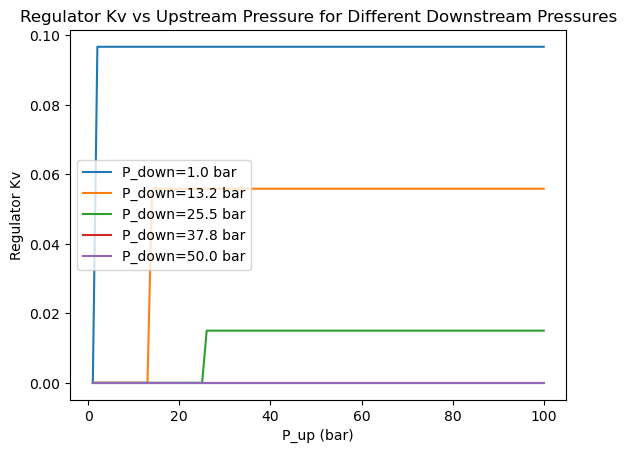

In [5]:
# Test regulator

P_downs = np.linspace(1e5, 50e5, 5)
P_ups = np.linspace(1e5, 100e5, 100)

for P_down in P_downs:
    reg_kvs = regulator_kv(P_ups, P_down, set_pressure=30e5)
    plt.plot(P_ups / 1e5, reg_kvs, label=f'P_down={P_down/1e5:.1f} bar')
plt.xlabel('P_up (bar)')
plt.ylabel('Regulator Kv')
plt.title('Regulator Kv vs Upstream Pressure for Different Downstream Pressures')
plt.legend()
plt.show()

## Hard coded IVP test

In [2]:
N2 = Gas(R= 296.8, gamma = 1.4)
O2 = Gas(R= 259.8, gamma = 1.4)
IPA = Liquid(density = 800)

V_1 = 3 * 0.001 #3L HP Tank
V_2 = 10 * 0.001 #10L LP Tank (Thomas)

#Starting densities
T_0 = 273.15 + 10

rho_1_0 = 300e5 / (N2.R * T_0) #rho = P / RT
rho_2_0 = 35e5 / (N2.R * T_0) #rho = P / RT

m_3 = 8 * 0.001 * IPA.density #8L IPA
m_1_0 = V_1 * rho_1_0
m_2_0 = (V_2 - m_3/IPA.density) * rho_2_0 

def test_dae_system(t, z):
    m_1, m_2, m_3 = z

    # m_1 is nitrogen tank
    # m_2 is amount of nitrogen in IPA tank
    # m_3 is amount of IPA in IPA tank

    # Explicit Algebraic Equations
    rho_1 = m_1 / V_1
    rho_2 = m_2 / (V_2-m_3/IPA.density)

    T_1 = T_0 * (rho_1_0 / rho_1) ** (1 - N2.gamma)
    T_2 = T_0 * (rho_2_0 / rho_2) ** (1 - N2.gamma)

    P_1 = rho_1 * N2.R * T_1
    P_2 = rho_2 * N2.R * T_2

    reg_pressure = 35e5
    reg_dp = reg_pressure - P_2
    reg_kv = np.where(reg_dp > 0, reg_dp / 300 / 1e5, 0.0)



    mdot_1 = - gasFlowrate(reg_kv, P_1, P_2, 300, N2)
    mdot_2 = - mdot_1
    mdot_3 = - liquidFlowrate(timed_valve_kv(t, maxKv=0.2, t_open=0.5, t_close=4.5, t_ramp=0.5), P_2, 1e5, IPA)

    return mdot_1, mdot_2, mdot_3



z0 = [m_1_0, m_2_0, m_3]
t_span = (0, 10)
t_eval = np.linspace(*t_span, 200)
# # Solve the system
solution = solve_ivp(test_dae_system, t_span, z0, t_eval=t_eval, method="LSODA")

t = solution.t
m_1, m_2, m_3 = solution.y
rho_1 = m_1 / V_1
rho_2 = rho_2 = m_2 / (V_2-m_3/IPA.density)
T_1 = T_0 * (rho_1_0 / rho_1) ** (1 - N2.gamma)
T_2 = T_0 * (rho_2_0 / rho_2) ** (1 - N2.gamma)

P_1 = rho_1 * N2.R * T_1
P_2 = rho_2 * N2.R * T_2

# # Plot the results
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax1 = ax[0,0]
ax1.plot(t, m_1, label="HP Tank", color='red')
ax1.set_ylabel('HP Tank Mass (kg)', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xlabel('Time (s)')

ax2 = ax1.twinx()
ax2.plot(t, m_2, label="LP Gas", color='blue')
ax2.set_ylabel('LP Gas (kg)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax3 = ax1.twinx()
ax3.plot(t, m_3, label="IPA", color='green')
ax3.tick_params(axis='y', labelcolor='g')
ax3.set_ylabel('IPA (kg)', color='g')
ax3.spines['right'].set_position(('outward', 60))

ax4 = ax[0,1]


ax4.plot(solution.t, P_1 / 1e5, label="HP Gas", color='red')
ax5 = ax4.twinx()
ax4.set_ylabel('HP Tank Pressure (bar)', color='r')
ax4.tick_params(axis='y', labelcolor='r')
ax5.plot(solution.t, P_2 / 1e5, label="LP Tank", color='blue')
ax5.set_ylabel('LP pressure (bar)', color='black')
ax5.tick_params(axis='y', labelcolor='black')
ax5.legend(loc='upper right')

axb1 = ax[1,0]
axb1.plot(t, gasFlowrate(np.where(P_2 < 35e5, (35e5 - P_2) / 300 / 1e5, 0), P_1, P_2, T_1, N2), label = "Nitrogen mass flow", color='red')
axb1.legend(loc='center right')
axb1.set_xlabel('Time (s)')

axb2 = ax[1,1]
axb2.plot(t,liquidFlowrate(timed_valve_kv(t, maxKv=0.2, t_open=0.5, t_close=4.5, t_ramp=0.5), P_2, 1e5, IPA), label = "Fuel mass flow", color='b')
axb2.set_xlabel('Time (s)')
axb2.set_ylabel('Fuel mass flow (kg/s)', color='b')
axb2.legend(loc='center right')

fig.tight_layout()

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed